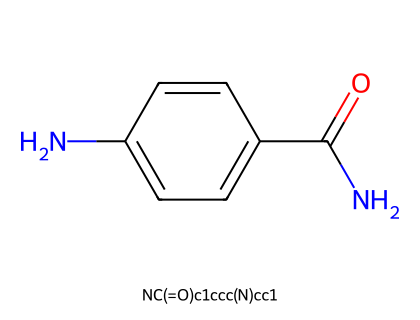

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xa4\x00\x00\x01@\x08\x02\x00\x00\x00|\xfb\x9f\xf6\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xed\xddy\\Te\xdb\x07\xf0\xdf\x0c\x83,\x82\x82\x0b"J\xa2(\x9b\x1b\x8b\x88[\xa5&Y\x8f\xfb^\x16\xb9\xe5\xae\x88\x0b*\xa1\xa6f*\x81\x8a\x0b\x95\xa6\xbe\xb9/hie\xee\x95f\xa2\xb9/\xa4\x80\xca"(" \x0c;\xcc\xcc\xfd\xfeq|&\x1fe\x06\x84\xe1\x9c\x999\xd7\xf7\xd3\x1f\xcc\x99\x8b3\xd7\x90\xfc8s\xce}\xee[\xc2\x18\x03!\x84\x18;\xa9\xd0\r\x10B\x08\x1f(\xec\x08!\xa2@aG\x08\x11\x05\n;B\x88(P\xd8\x11BD\x81\xc2\x8e\x10"\n\x14v\x84\x10Q\xa0\xb0#\x84\x88\x02\x85\x1d!D\x14(\xec\x08!\xa2@aG\x08\x11\x05\n;B\x88(P\xd8\x11BD\x81\xc2\x8e\x10"\n\x14v\x84\x10Q\xa0\xb0#\x84\x88\x02\x85\x1d!D\x14(\xec\x08!\xa2@aG\x08\x11\x05\n;B\x88(P\xd8\x11BD\x81\xc2\x8e\x10"\n\x14v\x84\x10Q\xa0\xb0#\x84\x88\x02\x85\x1d!D\x14(\xec\x08!\xa2@aG\x08\x11\x05\n;B\x88(P\xd8\x11BD\x81\xc2\x8e\x10"\n\x14v\x84\x10Q\xa0\xb0#\x84\x88\x02\x85\x1d!D\x14(\xec\x08!\xa

In [12]:
# 如果尚未安装 rdkit，请先在终端或 notebook 里运行：
# conda install -c conda-forge rdkit
# 或者
# pip install rdkit-pypi

from typing import List, Optional, Union
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.rdMolDraw2D import MolDraw2DCairo, MolDraw2DSVG

def mol_from_smiles(smiles: str):
    """将 SMILES 转为 RDKit Mol，失败则返回 None。"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # 2D 构象，用于更美观的绘制
    AllChem.Compute2DCoords(mol)
    return mol

def smiles_to_image(
    smiles: str,
    size: tuple = (400, 300),
    highlight_atoms: Optional[List[int]] = None,
    show_smiles_caption: bool = True,
    out: Optional[Union[str, Path]] = None,
    fmt: str = "png",  # 支持 "png" 或 "svg"
):
    """
    将单个 SMILES 渲染为分子图像并可选保存。
    - highlight_atoms: 传入要高亮的原子索引列表（可选）
    - out: 保存路径（可选）。不传则仅在 notebook 中显示。
    - fmt: "png" 或 "svg"
    """
    mol = mol_from_smiles(smiles)
    if mol is None:
        print(f"[!] 无法解析 SMILES：{smiles}")
        return None

    w, h = size
    if fmt.lower() == "svg":
        drawer = MolDraw2DSVG(w, h)
    else:
        drawer = MolDraw2DCairo(w, h)

    # 可选标题
    legend = smiles if show_smiles_caption else ""
    # 准备绘图
    rdMolDraw2D.PrepareAndDrawMolecule(
        drawer,
        mol,
        highlightAtoms=highlight_atoms or [],
        legend=legend,
    )
    drawer.FinishDrawing()

    if fmt.lower() == "svg":
        svg = drawer.GetDrawingText()
        # 在 notebook 中显示 SVG
        from IPython.display import SVG, display
        display(SVG(svg))
        if out:
            Path(out).write_text(svg, encoding="utf-8")
        return svg
    else:
        png = drawer.GetDrawingText()
        from IPython.display import Image, display
        display(Image(data=png))
        if out:
            Path(out).write_bytes(png)
        return png

def smiles_list_to_grid(
    smiles_list: List[str],
    mols_per_row: int = 5,
    sub_img_size: tuple = (250, 200),
    legends: Optional[List[str]] = None,
    bad_tag: str = "[invalid SMILES]",
    out: Optional[Union[str, Path]] = None,
    dpi: int = 200,
):
    """
    批量绘制 SMILES 网格图（PIL Image），并可选保存 PNG。
    - legends: 每个分子的文字标签（默认用 SMILES；无效则标注 bad_tag）
    """
    mols = []
    final_legends = []
    for i, s in enumerate(smiles_list):
        mol = mol_from_smiles(s)
        mols.append(mol)
        if legends is not None and i < len(legends):
            final_legends.append(legends[i] if mol is not None else f"{legends[i]} {bad_tag}")
        else:
            final_legends.append(s if mol is not None else f"{s} {bad_tag}")

    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=mols_per_row,
        subImgSize=sub_img_size,
        legends=final_legends,
        useSVG=False,  # 这里输出 PIL Image，适合保存 PNG
    )
    # 在 notebook 中显示
    display(img)

    if out:
        out = Path(out)
        img.save(out, dpi=(dpi, dpi))
    return img

# =========================
# 使用示例
# =========================

# 1) 单个 SMILES → 图片
example = "NC(=O)c1ccc(N)cc1"

smiles_to_image(example, size=(420, 320), fmt="png")

# # 2) 批量 SMILES → 网格图
# test_smiles = [
#     "CC(=O)OC1=CC=CC=C1C(=O)O",  # Aspirin
#     "O=C(NC1=CC=C(O)C=C1)C2=NC=NC(N)=N2",  # Caffeine（示例 SMILES 之一）
#     "C1=CC=CC=C1",                # Benzene
#     "C(C(=O)O)N",                 # Glycine
#     "N[C@@H](CCC(=O)O)C(=O)O",    # Glutamic acid
#     "this_is_not_a_smiles",       # 无效示例
# ]
# smiles_list_to_grid(test_smiles, mols_per_row=3, sub_img_size=(260, 210))